In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange

from torchtext.data import Field
from torchtext.vocab import GloVe
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from transformers import BertTokenizer, BertModel

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

from utils import preprocessing
from utils.training import train, infer, predict_sexism

sns.set_style('darkgrid')

In [2]:
# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# BERT

## Datos

In [4]:
train_df = pd.read_csv('../../Data/EXIST2021_training.tsv', sep='\t')

# Un simple pre-procesamiento
train_df['text'] = train_df['text'].apply(lambda text: preprocessing.preprocess(text))

# Codificamos las etiquetas
label_encoder = LabelEncoder()
label_encoder.fit(train_df['task1'])

train_df['label'] = label_encoder.transform(train_df['task1'])

train_df.head()

,test_case,id,source,language,text,task1,task2,label
0,EXIST2021,1,twitter,en,"she calls herself "" anti-feminazi "" how about ...",sexist,ideological-inequality,1
1,EXIST2021,2,twitter,en,"now , back to these women , the brave and the ...",non-sexist,non-sexist,0
2,EXIST2021,3,twitter,en,"wow , your skirt is very short . what is it's ...",sexist,objectification,1
3,EXIST2021,4,twitter,en,incredible ! beautiful ! but i laughed so much...,non-sexist,non-sexist,0
4,EXIST2021,5,twitter,en,i find it extremely hard to believe that kelly...,non-sexist,non-sexist,0


In [5]:
test_df = pd.read_csv('../../Data/EXIST2021_test.tsv', sep='\t')

# Un simple pre-procesamiento
test_df['text'] = test_df['text'].apply(lambda text: preprocessing.preprocess(text))

test_df['label'] = label_encoder.transform(test_df['task1'])

test_df.head()

,test_case,id,source,language,text,task1,task2,label
0,EXIST2021,6978,gab,en,pennsylvania state rep horrifies with opening ...,non-sexist,non-sexist,0
1,EXIST2021,6979,twitter,en,"he sounds like as ass , and very condescending .",non-sexist,non-sexist,0
2,EXIST2021,6980,twitter,en,"lol ! "" this behavior of not letting men tell ...",sexist,ideological-inequality,1
3,EXIST2021,6981,twitter,en,rights ? i mean yeah most women especially the...,sexist,ideological-inequality,1
4,EXIST2021,6982,twitter,en,the jack manifold appreciation i ’ m seeing is...,non-sexist,non-sexist,0


### Dataloaders

En [Huggingface models](https://huggingface.co/models) están los modelos pre-entrenados disponibles. Usaré [bert-base-multilingual-uncased](https://huggingface.co/bert-base-multilingual-uncased) que está pre-entrenado en 102 idiomas con un corpus de Wikipedia.

In [6]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
# bert = BertModel.from_pretrained('bert-base-multilingual-uncased')

# tokenizer(['hello my name is dave']), tokenizer(['hola mi nombre es david'])

In [7]:
class DataSet:    
    def __init__(self, file):
        self.y = torch.tensor(file['label'].to_numpy(), dtype=torch.long)
        self.texts = file['text'].tolist()
        
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
        
    def __getitem__(self, i):
        inputs1 = self.tokenizer(self.texts[i], max_length=128, padding='max_length', truncation=True, return_tensors='pt')
        return torch.squeeze(inputs1['input_ids']), torch.squeeze(inputs1['attention_mask']), torch.squeeze(self.y[i])
        
    def __len__(self):
        return len(self.y)
    
class DataSetText:
    
    def __init__(self, file):
        self.y = torch.tensor(file['label'].to_numpy(), dtype=torch.long)
        self.texts = file['text'].tolist()
        
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
        
    def __getitem__(self, i):
        inputs1 = self.tokenizer(self.texts[i], max_length=128, padding='max_length', truncation=True, return_tensors='pt')
        return torch.squeeze(inputs1['input_ids']), torch.squeeze(inputs1['attention_mask']), torch.squeeze(self.y[i])
        
    def __len__(self):
        return len(self.y)

In [8]:
ds_text_train = DataSetText(train_df)
ds_text_test = DataSetText(test_df)

print(f'Train: {len(ds_text_train)}')
print(f'Test: {len(ds_text_test)}')

Train: 6977
Test: 4368


In [9]:
# Si hago el batch más grande puede que no quepa en la GPU
BATCH_SIZE = 8

train_dl = DataLoader(
    ds_text_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    drop_last=True)

test_dl = DataLoader(
    ds_text_test,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4)

## Modelo

In [10]:
class SexismClassifier(nn.Module):
    def __init__(self):
        super(SexismClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-multilingual-uncased')
        
        self.dropout = nn.Dropout()
                
        self.clf = nn.Sequential(nn.Linear(768, 2), 
                                 nn.Softmax(dim=1))
        
    def forward(self, ids, masks):
        # [batch_size, max_length] -> [batch_size, max_length, 768]
        bert_output = self.bert(input_ids=ids, attention_mask=masks, return_dict=True).last_hidden_state
        
        bert_output = self.dropout(bert_output)
        
        # [batch_size, max_length, 768] -> [batch_size, 768]
        # cls_output = bert_output[:,0,:]
        cls_output = bert_output[:,0,:]
        
        # [batch_size, 768] -> [batch_size, 2]
        y = self.clf(cls_output)

        return y 

In [11]:
model = SexismClassifier().to(device)

In [12]:
summary(model)

Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         --
|    └─BertEmbeddings: 2-1               --
|    |    └─Embedding: 3-1               81,315,072
|    |    └─Embedding: 3-2               393,216
|    |    └─Embedding: 3-3               1,536
|    |    └─LayerNorm: 3-4               1,536
|    |    └─Dropout: 3-5                 --
|    └─BertEncoder: 2-2                  --
|    |    └─ModuleList: 3-6              85,054,464
|    └─BertPooler: 2-3                   --
|    |    └─Linear: 3-7                  590,592
|    |    └─Tanh: 3-8                    --
├─Dropout: 1-2                           --
├─Sequential: 1-3                        --
|    └─Linear: 2-4                       1,538
|    └─Softmax: 2-5                      --
Total params: 167,357,954
Trainable params: 167,357,954
Non-trainable params: 0

### Entrenamiento

In [13]:
%time accs_train, accs_test = train(model, train_dl, test_dl, epochs=5)

  0%|          | 0/872 [00:00<?, ?it/s]

Epoch 0: train acc:0.6744552752293578 test acc:0.7275641025641025


  0%|          | 0/872 [00:00<?, ?it/s]

Epoch 1: train acc:0.7838302752293578 test acc:0.757554945054945


  0%|          | 0/872 [00:00<?, ?it/s]

Epoch 2: train acc:0.8319954128440367 test acc:0.7467948717948718


  0%|          | 0/872 [00:00<?, ?it/s]

Epoch 3: train acc:0.8625286697247706 test acc:0.75


100%|██████████| 872/872 [02:07<00:00,  6.86it/s]


Epoch 4: train acc:0.8827408256880734 test acc:0.7351190476190477
CPU times: user 12min 11s, sys: 26.7 s, total: 12min 37s
Wall time: 12min 39s


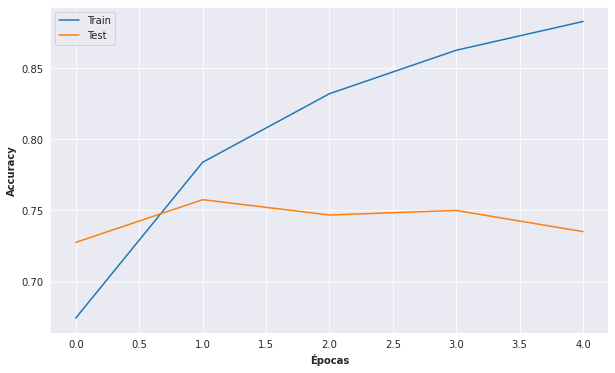

In [14]:
plt.figure(figsize=(10,6))
plt.plot(accs_train, label='Train')
plt.plot(accs_test, label='Test')

plt.xlabel('Épocas', weight='bold')
plt.ylabel('Accuracy', weight='bold')
plt.legend()

plt.show()

### Evaluación

In [15]:
%time y_test, y_pred = infer(model, test_dl)

CPU times: user 19.6 s, sys: 242 ms, total: 19.9 s
Wall time: 20.1 s


In [16]:
print(f'Accuracy: {100*round(accuracy_score(y_test, y_pred), 4)}')
print(f'F1 score: {100*round(f1_score(y_test, y_pred), 4)}')

Accuracy: 73.50999999999999
F1 score: 73.24000000000001


In [17]:
text = 'shut up bitch you are useless'

predict_sexism(model, 'text', label=True)

'non-sexist'